### Setup

In [1]:
#do not run unless tensorflow can't find cuda
import os
os.environ['CUDA_DIR'] = "/usr/lib/cuda"
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/lib/cuda"

In [2]:
import tensorflow as tf

2024-04-23 18:37:37.147898: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 18:37:37.173850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 18:37:37.173870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 18:37:37.174791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 18:37:37.179282: I tensorflow/core/platform/cpu_feature_guar

In [3]:
tf.__version__

'2.15.0'

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow.keras import layers
import tensorflow_probability as tfp

import time

from IPython import display

### Load and prepare the dataset

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 16

We load the training data and apply some flips and rotations to augment it.

In [10]:
import os
import os.path as osp
import cv2
import numpy as np
import pandas as pd

# path = '../padded_seg2ct3'
path = '../cropped_healthy_vertebra'

images = []

for image_file in os.listdir(path):

    img = cv2.imread(osp.join(path, image_file), cv2.IMREAD_GRAYSCALE)
    
    imgflipleft = cv2.flip(img, 1)

    imgflipup = cv2.flip(img, 0)

    imgrot180 = cv2.rotate(img, cv2.ROTATE_180)
    images.append(img)

    images.append(imgflipleft)
    images.append(imgflipup)
    images.append(imgrot180)
        
images = np.array(images)

In [11]:
images.shape

(1508, 128, 128)

Normalize by dividing by max sinse sigmoid is applied to the last layer of the VAE decoder.

In [12]:
images = (images) / 255

In [16]:
train_size = images.shape[0]


In [17]:
images = images.reshape(images.shape[0], 128, 128, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(train_size).batch(BATCH_SIZE)

2024-04-23 18:37:58.331407: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 18:37:58.361596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 18:37:58.361745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

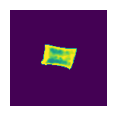

In [18]:
import matplotlib.pyplot as plt

my_dpi = 100
plt.figure(figsize=(1.28, 1.25), dpi=my_dpi)
plt.axis('off')
plt.imshow((images[90,:,:,:]*127.5 + 127.5).astype('int'))
plt.show()

## Create the models

### The Generator

The generator is a VAE (the decoder part of the VAE is what we care about mostly). It will be trained as a VAE and GAN.

In [19]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def generate(self, mean, logvar):
    z = self.reparameterize(mean, logvar)
    x_logit = self.decode(z, apply_sigmoid=True)
    return x_logit

Use the (as yet untrained) generator to create an image.

2024-04-23 18:38:11.937031: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


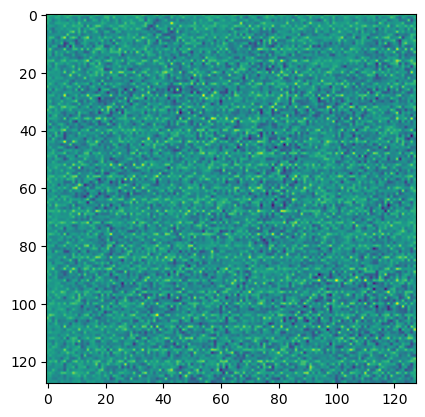

In [20]:
latent_dim = 20
generator = CVAE(latent_dim)
# generator.load_weights('./ddi_generator_ham_benign')

noise_mean = tf.random.normal([1, latent_dim])
noise_logvar = tf.random.normal([1, latent_dim])

generated_image = generator.generate(noise_mean, noise_logvar)

plt.imshow(generated_image[0, :, :, 0])

### The Discriminator

The discriminator is a CNN-based image classifier.

In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1],trainable=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',trainable=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [22]:
discriminator = make_discriminator_model()
# discriminator.load_weights('./ddi_discriminator_ham_benign')

decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.02077233]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [23]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [25]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### VAE loss

Here the VAE loss is calculated as the sum of the cross entropy loss and the kl-loss. The kl-loss ensures that the latent space converges to a continuous normal distribution with mean of zero and standard deviation of 1.

In [26]:
def compute_elbo_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  reconstruction_loss = tf.reduce_mean(
      tf.reduce_sum(
          tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x),
          axis=(1, 2, 3),
      )
  )
  kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.square(tf.exp(logvar)))
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  total_loss = reconstruction_loss + kl_loss
  return total_loss

The discriminator and the generator optimizers are different since we will train two networks separately. We will also train the VAE aspect of the network seperately.

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(0.25*1e-4)
elbo_optimizer = tf.keras.optimizers.Adam(0.25*1e-4)

### Save checkpoints

In [28]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

## Define the training loop


In [29]:
EPOCHS = 2000
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, latent_dim])
seed2 = tf.random.normal([num_examples_to_generate, latent_dim])

There are two training loops here:

VAE Loop:

The VAE encoder and decoder are trained as a regular VAE ignoring the discriminator. The VAE is shown images from the dataset and tasked with reproducing them and learning a continous and rich latent space along the way.

GAN Loop:

The VAE encoder is ignored and the VAE decoder is treated as the GAN generator and trained alongside the discriminator. The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.


In [30]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_elbo(images):
    with tf.GradientTape() as tape:
        loss = compute_elbo_loss(generator, images)
    gradients = tape.gradient(loss, generator.trainable_variables)
    elbo_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))


@tf.function
def train_step(images):

    # with tf.GradientTape() as tape:
    #     loss = compute_elbo_loss(generator, images)
    # gradients = tape.gradient(loss, generator.trainable_variables)
    # elbo_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    
    noise_mean = tf.random.normal([BATCH_SIZE, latent_dim])
    noise_logvar = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator.generate(noise_mean, noise_logvar)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.decoder.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.decoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss

The trainig function below applies the training steps, plots the losses, calculates and plots the FID, and plots sample images produced by the genrator.

We first apply the VAE training step ignoring the discriminator, and them we apply the GAN training step ignoring the VAE encoder.

In [31]:
gen_losses = []
disc_losses = []
fids = []
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    average_gen_loss = 0
    average_disc_loss = 0
    for i,image_batch in enumerate(dataset):
      train_step_elbo(image_batch)
    for i,image_batch in enumerate(dataset):
      gen_loss,disc_loss = train_step(image_batch)
      average_gen_loss += gen_loss.numpy()
      average_disc_loss += disc_loss.numpy()
    average_gen_loss /= i
    average_disc_loss /= i
    
    gen_losses.append(average_gen_loss)
    disc_losses.append(average_disc_loss)
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed, seed2)
    learning_curves(gen_losses,disc_losses)
    
    if (epoch) % 10 == 0:
        fids.append(fid(generator,images))
    plot_fids(fids)
    # Save the model every 15 epochs
#     if (epoch + 1) % 15 == 0:
#       checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print('Generator loss:',average_gen_loss)
    print('Discriminator loss:',average_disc_loss)
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, seed2)


**Generate and save images**


In [32]:
def generate_and_save_images(model, epoch, test_mean, test_log_var):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  z = model.reparameterize(test_mean, test_log_var)
  predictions = model.sample(z)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :], cmap='gray')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

**Generate learning curve**

In [33]:
def learning_curves(genrator_list_of_losses,discriminator_list_of_losses):
    plt.plot(genrator_list_of_losses)
    plt.plot(discriminator_list_of_losses)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

**Calculate FID**

In [34]:
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
from skimage.transform import resize
from numpy import asarray
from numpy.random import randint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

def fid(generator,images):
    generated_images = []
    for i in range(1000):
        noise_mean = tf.random.normal([1, latent_dim])
        noise_logvar = tf.random.normal([1, latent_dim])
        generated_images.append(np.array(generator.generate(noise_mean, noise_logvar)).reshape((128,128,1)))

    generated_images = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in generated_images])
    images = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in images])
    
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))
    def calculate_fid(model, images1, images2):
        # calculate activations
        act1 = model.predict(images1)
        act2 = model.predict(images2)
        # calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

    def scale_images(images, new_shape):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return asarray(images_list)
    
    images1 = scale_images(images, (75,75,3))
    images2 = scale_images(generated_images, (75,75,3))

    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

    fid = calculate_fid(model, images1, images2)
    
    del model
    del generated_images
    
    return fid

In [35]:
def plot_fids(fids):
    plt.plot(fids)
    plt.title('FIDs')
    plt.ylabel('FID')
    plt.xlabel('epoch')
    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

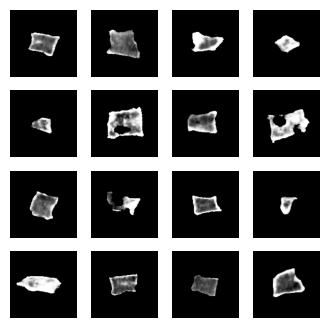

In [41]:
train(train_dataset, EPOCHS)

In [64]:
from scipy.spatial.distance import cdist
def diversityRatioCalc(generator, images):
    generated_images = []
    for i in range(1000):
        noise_mean = tf.random.normal([1, latent_dim])
        noise_logvar = tf.random.normal([1, latent_dim])
        generated_images.append(np.array(generator.generate(noise_mean, noise_logvar)).reshape((128*128)))

    generated_images = np.array(generated_images)
    images = np.array([gray.reshape((128*128)) for gray in images])
    
    disctances_gen_and_real = cdist(generated_images, images)
    distances_real_and_real = cdist(images, images)
    return np.mean(np.where(disctances_gen_and_real>0, disctances_gen_and_real, np.inf).min(axis=0))/np.mean(np.where(distances_real_and_real>0, distances_real_and_real, np.inf).min(axis=0))
diversityRatioCalc(generator, images)

1.0767412689057831

## Save the models, the loss and FID curves.

In [42]:
generator.save_weights('./real_healthy_cts_variational_autoencoder_generator')
discriminator.save_weights('./real_healthy_cts_variational_autoencoder_discriminator')

In [43]:
import csv
with open('variational_autoencoder_generator_loss_real_healthy_cts.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(gen_losses)
with open('variational_autoencoder_discriminator_loss_real_healthy_cts.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(disc_losses)
with open('FIDs_variational_autoencoder_real_healthy_cts.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(fids)